<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цель-проекта" data-toc-modified-id="Цель-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Цель проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#План-работы" data-toc-modified-id="План-работы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>План работы</a></span><ul class="toc-item"><li><span><a href="#Часть-1.-Подготовка-и-обработка-данных" data-toc-modified-id="Часть-1.-Подготовка-и-обработка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Часть 1. Подготовка и обработка данных</a></span></li><li><span><a href="#Часть-2.-Изучение-воронки-событий" data-toc-modified-id="Часть-2.-Изучение-воронки-событий-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Часть 2. Изучение воронки событий</a></span></li><li><span><a href="#Часть-3.-Изучение-результатов-эксперимента" data-toc-modified-id="Часть-3.-Изучение-результатов-эксперимента-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Часть 3. Изучение результатов эксперимента</a></span></li><li><span><a href="#Часть-4.-Вывод" data-toc-modified-id="Часть-4.-Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Часть 4. Вывод</a></span></li></ul></li></ul></div>

# Анализ поведения пользователей в мобильном приложении


## Цель проекта

Нужно проанализировать поведение пользователей мобильного приложения на основании логов пользователей и результатов А/А/В - эксперимента, в котором для тестовой группы клиентов поменяли шрифты в приложении.

## Описание данных

Файл с логами пользователей <code>logs_exp.csv</code>
<div>

* <code>EventName</code> — название события;

* <code>DeviceIDHash</code> —  уникальный идентификатор пользователя;

* <code>EventTimestamp</code> — время события;

* <code>ExpId</code> — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
    
</div>

## План работы

Исследование пройдет в 4 этапа:

<div>

* <b>Часть 1. Подготовка и обработка данных</b>

* <b>Часть 2. Изучение воронки событий</b>
    
* <b>Часть 3. Изучение результатов эксперимента</b>

* <b>Часть 4. Вывод</b>    
    

### Часть 1. Подготовка и обработка данных

In [76]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
from IPython.display import set_matplotlib_formats
from pandas.plotting import register_matplotlib_converters
import warnings; warnings.filterwarnings(action = 'ignore') 
register_matplotlib_converters()
sns.set()
pd.options.display.max_colwidth = 150

In [77]:
pth1 = '/datasets/logs_exp.csv'
pth2 = 'logs_exp.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, sep='\t')
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, sep='\t')
else:
    print('Что-то пошло не так')

Обзор данных

In [78]:
data.shape

(244126, 4)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [80]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [81]:
data['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [82]:
data['ExpId'].unique()

array([246, 248, 247])

In [83]:
#Проверка на дубликаты
display(data.duplicated().sum())
data.duplicated().sum()/len(data)

413

0.0016917493425526163

In [84]:
#Проверка на пропуски
data.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

В таблице 244 126 строк. Всего у нас 5 событий, которые совершали пользователи. Есть дубликаты. Заменим названия столбцов на более удобные. Откорректируем тип данных в столбце EventTimestamp, а также добавим отдельный столбец с датой. Избавимся от дубликатов.

In [85]:
#Переименуем колонки
data.rename(columns = {'EventName':'event_name', 'DeviceIDHash':'user_id', 
                       'EventTimestamp':'date_time', 'ExpId':'group'}, inplace = True)
data.columns

Index(['event_name', 'user_id', 'date_time', 'group'], dtype='object')

In [86]:
data['date_time'] = pd.to_datetime(data['date_time'], unit='s')

In [87]:
data['date'] = pd.to_datetime(data['date_time'].dt.date)

In [88]:
#Удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [89]:
#Данные после обработки
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   date_time   243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [90]:
data.head()

,event_name,user_id,date_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Нужно проверить, не пересекаются ли пользователи в группах теста. Это важно, чтобы эксперимент прошел без искажений.

In [91]:
data.groupby('user_id')['group'].nunique().reset_index().query('group > 1')

,user_id,group


Данные обработаны, пользоваетли не пересекаются между группами теста, можно переходить к анализу.

### Часть 2. Изучение воронки событий

Разберемся, сколько всего событий в логе, сколько всего пользователей, сколько в среднем событий приходится на пользователя.

In [92]:
#data.event_name.nunique()
print(f'Всего событий в логе - {data.shape[0]}.')
print(f'Всего уникальных событий в логе - {data.event_name.nunique()}. Всего пользователей в логе - {data.user_id.nunique()}.') 
print(f'В среднем на одного пользователя приходится {len(data)/data.user_id.nunique()} событий.')

Всего событий в логе - 243713.
Всего уникальных событий в логе - 5. Всего пользователей в логе - 7551.
В среднем на одного пользователя приходится 32.27559263673685 событий.


Посмотрим, данными за какой период мы располагаем.

In [93]:
print(f'Минимальная дата в логе - {min(data.date)}. Максимальная дата в логе - {max(data.date)}')

Минимальная дата в логе - 2019-07-25 00:00:00. Максимальная дата в логе - 2019-08-07 00:00:00


Построим гистограмму с количеством пользователей по дате и времени, чтобы посмотреть, одинаково ли полные данные за весь период, или нет.

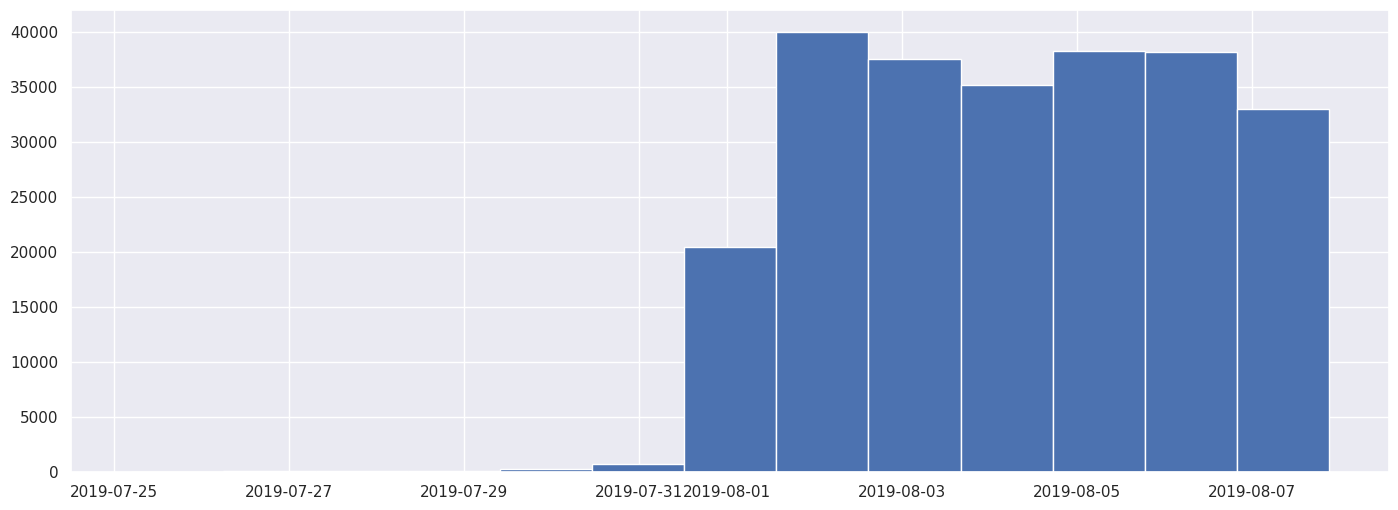

In [94]:
plt.figure(figsize=(17,6));
data.date_time.hist(bins = 13);

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Будем считать, что данные полные с 1 августа и отбросим более старые.

In [95]:
data_filtered = data.query('date >= "2019-08-01"')

Посмотрим, сколько событий и пользователей мы потеряли, отбросив старые данные

In [96]:
#События
display(data.shape[0] - data_filtered.shape[0])
100 - (data_filtered.shape[0] * 100 / data.shape[0])

2826

1.1595606307418933

In [97]:
#Пользователи
display(data.user_id.nunique() - data_filtered.user_id.nunique())
100 - (data_filtered.user_id.nunique() * 100 / data.user_id.nunique())

17

0.22513574361012445

Потери в событиях составили 2826 (1.2%), потери в пользователях - 17 (0.2%)

Посмотрим на распределение пользователей в тестовых группах

In [98]:
#По количеству событий
data_filtered.groupby(['group']).agg({'user_id': 'count'})

,user_id
group,
246,79302
247,77022
248,84563


In [99]:
#По количеству уникальных пользователей
data_filtered.groupby(['group']).agg({'user_id': 'nunique'})

,user_id
group,
246,2484
247,2513
248,2537


По количеству событий группы немного разнятся, больше всего их в экспериментальной группе 248. По количеству уникальных пользователей группы примерно одинаковы.

<b>Воронка событий</b>

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [100]:
events = data_filtered.groupby(['event_name']).agg({'user_id':'count'}).reset_index().sort_values(by='user_id', ascending=False)
events.rename(columns={'user_id':'total_events'}, inplace=True)
events

,event_name,total_events
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


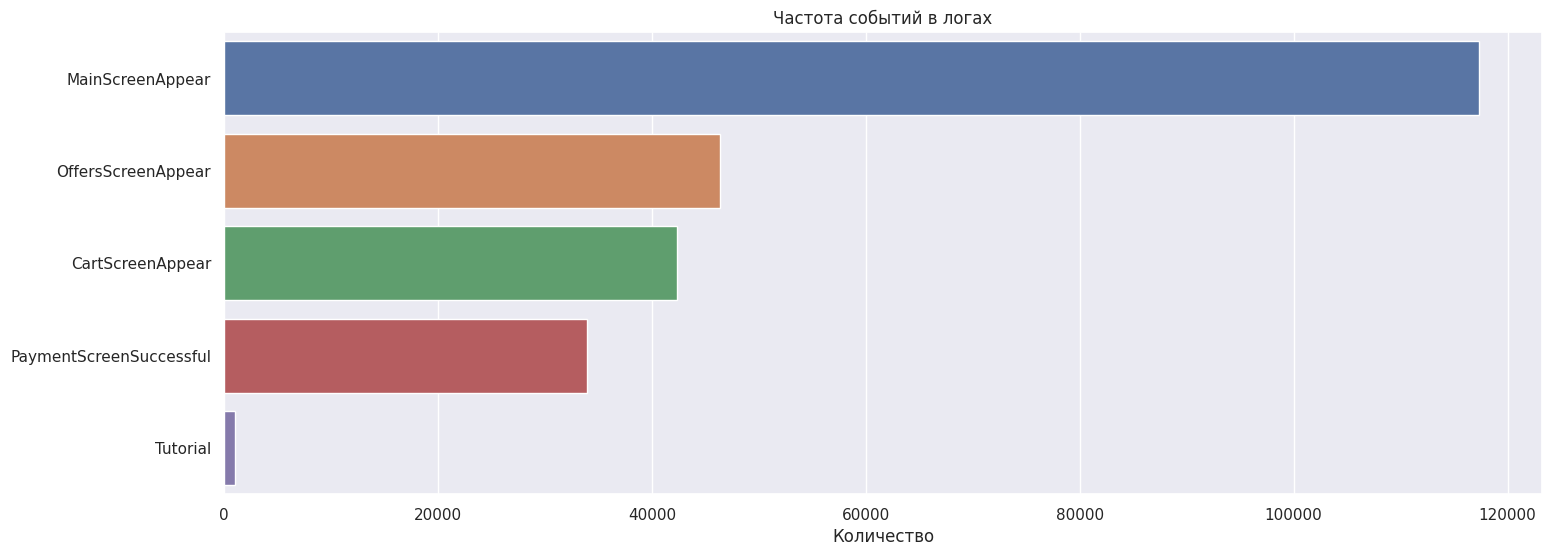

In [101]:
plt.figure(figsize=(17,6))
ax = sns.barplot(x='total_events', y='event_name', data=events, orient='h')
ax.set_title('Частота событий в логах')
ax.set_xlabel('Количество') 
ax.set_ylabel('') 
plt.show()

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [102]:
funnel =(
    data_filtered.groupby(['event_name']).agg({'user_id': 'nunique'}).
    reset_index().sort_values(by='user_id',ascending=False)
) 
funnel.rename(columns = {'user_id': 'total_users'}, inplace=True)
funnel['share'] = round(funnel['total_users'] / data_filtered['user_id'].nunique() * 100, 2)
funnel

,event_name,total_users,share
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Получили следующую информацию:

<div>

* Главную страницу просмотели 7419 пользователей (98.5% от всех пользователей);

* Страницу с предложениями увидели 4593 пользователя (70% от всех пользователей);
    
* Страницу с корзиной увидели 3734 пользователя (49.56% от всех пользователей);

* Страницу с успешной оплатой увидели 3539 пользователей (50% от всех пользователей);  
    
* Страницу с обучением увидело 840 пользователей (11% от всех пользователей);     

Все события выстраиваются в последовательную цепочку, кроме последнего. Скорее всего, обучение является не обязательным шагом, и часто пропускается. Не будем учитывать это событие при расчёте воронки.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C → D посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B и т.д.

In [103]:
funnel = funnel[funnel['event_name'] != 'Tutorial']

fig = go.Figure(go.Funnel(y = funnel['event_name'],
                          x = funnel['total_users'],
                          opacity = 0.6,
                          textposition = 'inside',
                          textinfo = 'value + percent previous'))
fig.update_layout(title_text='Воронка событий')
fig.show()

По получившейся воронке событий видим, что больше всего потерь на втором шаге (OffersScreenAppear) - 38 % пользователей. От первого события до оплаты доходит 47.7 % пользователей.

### Часть 3. Изучение результатов эксперимента

Посмотрим, сколько пользователей в каждой экспериментальной группе

In [104]:
data_filtered.groupby(['group']).agg(count=('user_id', 'nunique'))

,count
group,
246,2484
247,2513
248,2537


In [105]:
funnel_group = (data_filtered.
          groupby(['event_name', 'group']).
          agg({'user_id': 'nunique'}).
          reset_index().
          rename(columns={'user_id' : 'total_users'}).
          sort_values(by=['group','total_users'], ascending=False))

funnel_group = funnel_group[funnel_group['event_name'] != 'Tutorial']
funnel_group

,event_name,group,total_users
5,MainScreenAppear,248,2493
8,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1230
11,PaymentScreenSuccessful,248,1181
4,MainScreenAppear,247,2476
7,OffersScreenAppear,247,1520
1,CartScreenAppear,247,1238
10,PaymentScreenSuccessful,247,1158
3,MainScreenAppear,246,2450
6,OffersScreenAppear,246,1542


In [106]:
ig = go.Figure()

fig.add_trace(go.Funnel(name = '246',
                        y = funnel_group.query('group == 246')['event_name'],
                        x = funnel_group.query('group == 246')['total_users'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))

fig.add_trace(go.Funnel(name = '247',
                        y = funnel_group.query('group == 247')['event_name'],
                        x = funnel_group.query('group == 247')['total_users'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))


fig.add_trace(go.Funnel(name = '248',
                        y = funnel_group.query('group == 248')['event_name'],
                        x = funnel_group.query('group == 248')['total_users'],
                        opacity = 0.6,
                        textposition = 'inside',
                        textinfo = 'value + percent previous'))
                        
fig.update_layout(title_text='Воронка событий в разрезе тестовых групп')
fig.show()

В А/В-тестировании мы проводим проверку гипотезы о равенстве выборок, но перед этим мы сначала проводим А/А-тест, чтобы узнать, обнаруживают ли статистические критерии разницу между выборками 246 и 247. В этом случае мы используем Z-критерий, который является статистическим тестом для определения, различаются ли средние значения двух генеральных совокупностей, при условии, что дисперсии известны и размер выборки достаточно большой. Напишем функцию

In [107]:
def z_test(df1, df2, event, alpha, n):
      
    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
 
    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event_name'] == event]['user_id'].nunique(), 
                        df2[df2['event_name'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Мы должны сравнить доли для каждого события между следующими группами:
<div>

* Контрольные группы 246 и 247.;

* Каждая контрольная группа отдельно с экспериментальной группой (246-248 и 247-248).;

* Объединенная контрольная группа с экспериментальной группой (246+247 и 248).
    
</div>

У нас есть 4 вида событий, 4 A/A-теста и 12 A/B-тестов. Для обеспечения защиты от ложных результатов во всех тестах мы применяем поправку Бонферрони, где <code>bonferroni_alpha = alpha / 16</code>

Теперь сформулируем основные и альтернативные гипотезы для каждого попарного сравнения.

Сформулируем гипотезы:<br>
<b>H0: Доли уникальных посетителей на определенном этапе воронки одинаковы</b><br>
<b>Н1: Доли уникальных посетителей на определенном этапе воронки разные</b>

In [108]:
#Проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:

for event in funnel_group['event_name'].unique():
    z_test(data_filtered[data_filtered['group'] == 246], data_filtered[data_filtered['group'] == 247], event,.01, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между группами 246 и 247 ни по одному событию нет статистически значимого отличия при заданном уровне alpha, а значит, приступаем к A/B-тестированию.

In [109]:
#Проверим, есть ли статистически значимая разница между контрольными группами 246 и 248:

for event in funnel_group['event_name'].unique():
    z_test(data_filtered[data_filtered['group'] == 246], data_filtered[data_filtered['group'] == 248], event,.01, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При заданном уровне статистической значимости у нас нет оснований считать группы 246 и 248 разными.

In [110]:
#Проверим, есть ли статистически значимая разница между контрольными группами 247 и 248:

for event in funnel_group['event_name'].unique():
    z_test(data_filtered[data_filtered['group'] == 247], data_filtered[data_filtered['group'] == 248], event,.01, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



При заданном уровне статистической значимости у нас нет оснований считать группы 247 и 248 разными.

In [111]:
# проверим есть ли статистически значимая разница между объединённой контрольной и экпериментальной 248 группами:

for event in funnel_group['event_name'].unique():
    z_test(data_filtered[data_filtered['group'] != 248], data_filtered[data_filtered['group'] == 248], event,.01, 16)
    print()

Событие: MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Событие: PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Получаем такой же результат. Значит, можно сделать вывод о том, что изменение шрифтов в приложении на поведение пользователей не повлияло.

### Часть 4. Вывод

В ходе исследования было проанализировано поведение 7419 пользователей мобильного приложения на основе пользовательских логов и результатов A/A/B-теста. После предобработки данных были изучены следующие показатели:
<div>

* Главную страницу увидели 7419 пользователей (100% от общего числа пользователей);

* Страницу товара просмотрели 4593 пользователей (62% от общего числа);

* Карточку просмотрели 3734 пользователя (50,3% от общего числа).
    
* Завершили оплату 3539 пользователей (47,7% от общего числа).    
    
</div>

Событие "Tutorial" было исключено из анализа, так как его прохождение необязательно и не влияет на последующие шаги.

Большинство пользователей (38%) отсеивалось после первого шага, примерно 9% после следующего шага, и около 2% после перехода на последний шаг. В итоге, примерно 48% пользователей завершили процесс и совершили покупку.

Затем были проанализированы результаты A/A/B-эксперимента, в котором осуществлялось изменение шрифта во всем приложении. Для этого были использованы логи событий за неделю с 1 августа 2019 года по 7 августа 2019 года.

В эксперименте участвовали три группы пользователей:
<div>

* Группа 246: 2484 пользователя;

* Группа 247: 2513 пользователя;

* Группа 248: 2537 пользователя.
     
</div>

В соответствии с предложенным процессом, необходимо было сравнить доли пользователей для каждого события между:
<div>

* Контрольными группами 246 и 247;

* Каждой из контрольных групп отдельно с экспериментальной группой (246-248 и 247-248);

* Объединенной контрольной группой и экспериментальной группой (246+247 и 248).
     
</div>

В результате проведенных множественных A/B-тестов для каждого события не было обнаружено статистически значимых различий между группами. Это означает, что изменение шрифтов во всем приложении не оказало влияния на поведение пользователей.